# An exploratory notebook to develop graphics for the PSI NPP workshop (12/06/22)

In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import pandas as pd
import numpy as np
import yaml
import xarray as xr
import pathlib
import geopandas as gpd
import time
import sys
sys.path.insert(1, '../scripts/')
from create_2Dmedian_inlet_netcdf import create_2Dmedian_inlet_netcdf


In [2]:
# Use shapefile with inlet attributions, provided by Stefano Mazzilli
shp_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-grid/shapefiles/SSMGrid2_tce_ecy_node_info_v2_10102022_inlets')
shp = shp_dir/'SSMGrid2_tce_ecy_node_info_v2_10102022_inlets.shp'
gdf = gpd.read_file(shp)

In [9]:
gdf[['Inlet_name','Inlet_info']].groupby('Inlet_info').count().index.to_list()[1:]

['Bel_1_17m',
 'Bel_2_14m',
 'Bel_3_12m',
 'Bel_4_10m',
 'Bel_5_9m',
 'Case_1_50m',
 'Case_2_38m',
 'Case_3_27m',
 'Case_4_12m',
 'Case_5_4m',
 'Sin_1_12m',
 'Sin_2_10m',
 'Sin_3_9m',
 'Sin_4_8m',
 'Sin_5_6m']

In [16]:
gdf[gdf['Inlet_info']=='Bel_1_17m']['tce'].item()

6262

In [14]:
# Use 2014 baseline results
nc_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/')
nc_file = nc_dir/'NPP_workshop120622_WQM.nc'
ds = xr.open_dataset(nc_file)

In [11]:
sys.path.insert(1, '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/seawater')
from seawater import dens, svan, sigma

In [16]:
ds["salinity"][:,9,idx]

<xarray.DataArray 'salinity' (time: 8784, node: 22)>
array([[28.7793, 28.7953, 28.7399, ..., 28.3706, 28.3675, 28.487 ],
       [28.7885, 28.7892, 28.7339, ..., 28.3705, 28.3675, 28.4883],
       [28.7615, 28.7641, 28.684 , ..., 28.3343, 28.3511, 28.4245],
       ...,
       [29.0467, 29.0951, 29.0369, ..., 28.8526, 28.8187, 28.9297],
       [29.0695, 29.1256, 29.0547, ..., 28.8513, 28.8212, 28.9289],
       [29.0992, 29.1578, 29.0808, ..., 28.8505, 28.8229, 28.9268]],
      dtype=float32)
Coordinates:
  * time     (time) float32 43.2 3.637e+03 7.24e+03 ... 3.162e+07 3.162e+07
Dimensions without coordinates: node
Attributes:
    long_name:  salinity
    units:      1e-3

In [19]:
rho = 1024
g = 9.8
P = rho*g*ds["depth"][1,[1,2,3],1]

In [18]:
ds["depth"].max()

<xarray.DataArray 'depth' ()>
array(51510.4, dtype=float32)

In [20]:
from calc_density_NNP_workshop120622 import calc_density

In [ ]:
density = calc_density(0,idx)

loading netcdf


In [ ]:
# calculate density difference 

In [6]:
median = ds["NO3"][:,:,idx].quantile(0.5, dim=['node',"siglay"], skipna=True)

In [8]:
elapsed_time = 4.23124
print(f'Processing time: {elapsed_time:.2f} minutes')

Processing time: 4.23 minutes


In [23]:
#test=median.to_dict()

In [16]:
median_df = median.to_dataframe
median_df

<bound method DataArray.to_dataframe of <xarray.DataArray 'NO3' (time: 8784)>
array([0.39629801, 0.3981705 , 0.4155245 , ..., 0.40668701, 0.40576151,
       0.40564451])
Coordinates:
  * time      (time) float32 43.2 3.637e+03 7.24e+03 ... 3.162e+07 3.162e+07
    quantile  float64 0.5>

In [24]:
variable = "zeta"
median = ds[variable][:,idx].quantile(0.5,dim='node', skipna=True)
locals()[f"{variable}_median"]=median.rename('median')
zero_quantile = ds[variable][:,idx].quantile(0, dim='node', skipna=True)
locals()[f"{variable}_quantile_0"]=zero_quantile.rename('zero_quantile')
one_quantile = ds[variable][:,idx].quantile(1,dim='node', skipna=True)
locals()[f"{variable}_quantile_1"]=one_quantile.rename('one_quantile')

In [26]:
median = np.flip(median.transpose(),axis=0)
xr_combined = xr.merge([median, zero_quantile, one_quantile],compat='override')

In [30]:
xr_combined.to_dataframe().to_excel('test.xlsx')

In [55]:
xr_combined = xr.merge([locals()[f"{variable}_median"], locals()[f"{variable}_quantile_0"], locals()[f"{variable}_quantile_1"]],compat='override')

In [58]:
[*xr_combined]

['zeta_median', 'zeta_quantile_0', 'zeta_quantile_1']

In [57]:
variable = "zeta"
median = ds[variable][:,idx].quantile(0.5,dim='node', skipna=True)
median=median.rename(f"{variable}_median")
zero_quantile = ds[variable][:,idx].quantile(0, dim='node', skipna=True)
q_zero=zero_quantile.rename(f"{variable}_quantile_0")
one_quantile = ds[variable][:,idx].quantile(1,dim='node', skipna=True)
q_one=one_quantile.rename(f"{variable}_quantile_1")

xr_combined = xr.merge([median, q_zero, q_one],compat='override')

In [ ]:
with open('../etc/SSM_netcdf_config.ipynb', 'r') as config_file:
    ssm_nc = = yaml.safe_load(config_file) 

In [ ]:
variables = [*ssm_nc["label_dict"]]

In [4]:
%%time
for inlet in ["Sinclair Inlet"]:
    output_netcdf_dir = pathlib.Path(f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/NPP_workshop_120622/{inlet.split(" ")[0]}')
    for variable in ["salinity","B1","B2","NO3","netPP"]:
        create_2Dmedian_inlet_netcdf(
            nc_file, 
            shp, 
            output_netcdf_dir, 
            variable, 
            'median',
            inlet)

Creating 2D netcdf (depth, time) of median salinity in Sinclair Inlet
loading shapefile
loading netcdf
calculating median across inlet for each level and time step
Dimensions of salinity:  (8784, 10, 16012)
saving to: /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/NPP_workshop_120622/Sinclair/salinity_median_Sinclair Inlet_2DLevelsTime.nc
Creating 2D netcdf (depth, time) of median B1 in Sinclair Inlet
loading shapefile
loading netcdf
calculating median across inlet for each level and time step
Dimensions of B1:  (8784, 10, 16012)
saving to: /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/NPP_workshop_120622/Sinclair/B1_median_Sinclair Inlet_2DLevelsTime.nc
Creating 2D netcdf (depth, time) of median B2 in Sinclair Inlet
loading shapefile
loading netcdf
calculating median across inlet for each level and time step
Dimensions of B2:  (8784, 10, 16012)
saving to: /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/NPP_workshop_120622/Sinclair/B2_med

In [5]:
%%time
for inlet in ["Bellingham Bay", "Case Inlet", "Sinclair Inlet"]:
    output_netcdf_dir = pathlib.Path(f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/NPP_workshop_120622/{inlet.split(" ")[0]}')
    for variable in ["salinity","B1","B2","NO3","netPP"]:
        create_2Dmedian_inlet_netcdf(
            nc_file, 
            shp, 
            output_netcdf_dir, 
            variable, 
            'std',
            inlet)

Creating 2D netcdf (depth, time) of std salinity in Bellingham Bay
loading shapefile
loading netcdf
calculating median across inlet for each level and time step
Dimensions of salinity:  (8784, 10, 16012)
saving to: /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/NPP_workshop_120622/Bellingham/salinity_std_Bellingham Bay_2DLevelsTime.nc
Creating 2D netcdf (depth, time) of std B1 in Bellingham Bay
loading shapefile
loading netcdf
calculating median across inlet for each level and time step
Dimensions of B1:  (8784, 10, 16012)
saving to: /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/NPP_workshop_120622/Bellingham/B1_std_Bellingham Bay_2DLevelsTime.nc
Creating 2D netcdf (depth, time) of std B2 in Bellingham Bay
loading shapefile
loading netcdf
calculating median across inlet for each level and time step
Dimensions of B2:  (8784, 10, 16012)
saving to: /mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/NPP_workshop_120622/Bellingham/B2_std_Bellingh

# Plot 2D timeseries of spacial median across inlet

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


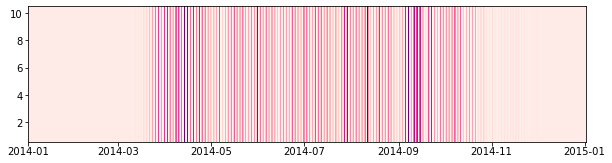

In [23]:
# create date vector
dti = pd.date_range("2014-01-01", periods=24*366, freq="H")

fig, axs = plt.subplots(1,1, figsize = (10,5*1/2),
    gridspec_kw={
       'width_ratios': [1],
       'height_ratios': [1], 
        'wspace': 0.25,
        'hspace': 0.25})
#create mesh
mesh2d=axs.pcolormesh(dti,[1,2,3,4,5,6,7,8,9,10],np.flip(ts2d.transpose(),axis=0),cmap='RdPu')


## Evaluate "Inlet_info", inclusive of confirming the meaning of `_Xm`

In [14]:
gdf[['Inlet_name','Inlet_info']].groupby('Inlet_info').count().rename(columns={'Inlet_name':'node count'})

,node count
Inlet_info,
<Null>,119
Bel_1_17m,1
Bel_2_14m,1
Bel_3_12m,1
Bel_4_10m,1
Bel_5_9m,1
Case_1_50m,1
Case_2_38m,1
Case_3_27m,1


In [19]:
gdf[['Inlet_info','depth']].groupby('Inlet_info').sum()

,depth
Inlet_info,
<Null>,2.907057
Bel_1_17m,0.017068
Bel_2_14m,0.014175
Bel_3_12m,0.011860
Bel_4_10m,0.010008
Bel_5_9m,0.008526
Case_1_50m,0.050264
Case_2_38m,0.038356
Case_3_27m,0.027159


### Confirmed: `_Xm` refers to depth of bathymetry

## Evaluate "Inlet_name" information

In [15]:
gdf[['Inlet_name','Inlet_info']].groupby('Inlet_name').count().rename(columns={'Inlet_info':'node count'})

,node count
Inlet_name,
Bellingham Bay,22
Case Inlet,100
Sinclair Inlet,12


In [17]:
gdf[['Inlet_name','km2']].groupby('Inlet_name').sum()

,km2
Inlet_name,
Bellingham Bay,62.501020
Case Inlet,31.479475
Sinclair Inlet,6.154808


### These are the nodes that I'll include in inlet analysis.  The sample sizes are different and the inlet areas are different, so I'll need to evaluation how these differences may skew results

# Create 2D (levels vs time) timeseries of:
- Median NPP within inlet (horizontally, across space)
- same as above with DO, NO3, B1, and B2
- Lineplots of median PAR and median bottom salinity - median surface salinity

# Create timeseries of:
- 50% quantile (median) NPP within inlet (space and depth) with shaded region showing range from 25% and 75% quantile
- same as above with DO, salinity, NO3, B1, and B2
- PAR